In [250]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('/Users/richardwestbrook/Library/Mobile Documents/com~apple~CloudDocs/Learning/Projects/baseball_game_stats.csv',index_col='Year',parse_dates=True)
df1 = pd.DataFrame(df[df.index >= '1946']['Time'])
df2 = pd.DataFrame(df['Inn%'])
df2.dropna(inplace=True)

In [251]:
df1 = df1[::-1]

In [190]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

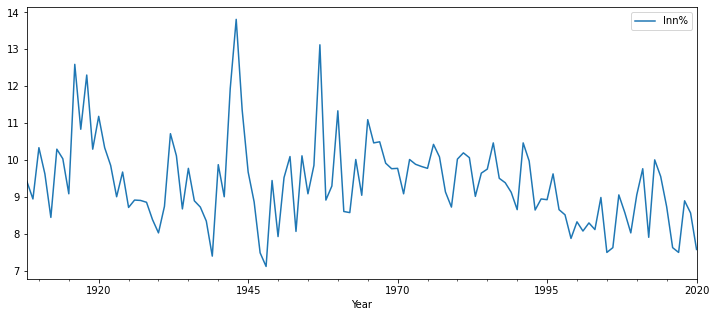

In [191]:
df2.plot(figsize=(12,5));

In [192]:
adf_test(df2['Inn%'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.837361
p-value                   0.000046
# lags used               3.000000
# observations          109.000000
critical value (1%)      -3.491818
critical value (5%)      -2.888444
critical value (10%)     -2.581120
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [193]:
auto_arima(df2['Inn%'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  113
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -166.959
Date:                Sun, 14 Feb 2021   AIC                            339.918
Time:                        14:24:35   BIC                            348.074
Sample:                             0   HQIC                           343.227
                                - 113                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3394      0.092      3.689      0.000       0.159       0.520
ma.L1         -0.9350      0.044    -21.185      0.000      -1.022      -0.849
sigma2         1.1397      0.115      9.873      0.000       0.913       1.366
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                12.76
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [194]:
test = df2.iloc[:30]
train = df2.iloc[30:]

In [195]:
model = ARMA(train['Inn%'],order=(1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Inn%   No. Observations:                   83
Model:                     ARMA(1, 1)   Log Likelihood                -125.855
Method:                       css-mle   S.D. of innovations              1.101
Date:                Sun, 14 Feb 2021   AIC                            259.710
Time:                        14:24:35   BIC                            269.386
Sample:                             0   HQIC                           263.597
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6458      0.193     49.995      0.000       9.268      10.024
ar.L1.Inn%     0.4885      0.210      2.331      0.020       0.078       0.899
ma.L1.Inn%    -0.1770      0.224     -0.789      0.430      -0.617       0.263
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0471           +0.0000j            2.0471            0.0000
MA.1            5.6502           +0.0000j            5.6502            0.0000
-----------------------------------------------------------------------------
"""

In [196]:
start=len(train.index)
end=len(train.index)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(1,1) Predictions')

In [197]:
test.index

DatetimeIndex(['2020-01-01', '2019-01-01', '2018-01-01', '2017-01-01',
               '2016-01-01', '2015-01-01', '2014-01-01', '2013-01-01',
               '2012-01-01', '2011-01-01', '2010-01-01', '2009-01-01',
               '2008-01-01', '2007-01-01', '2006-01-01', '2005-01-01',
               '2004-01-01', '2003-01-01', '2002-01-01', '2001-01-01',
               '2000-01-01', '1999-01-01', '1998-01-01', '1997-01-01',
               '1996-01-01', '1995-01-01', '1994-01-01', '1993-01-01',
               '1992-01-01', '1991-01-01'],
              dtype='datetime64[ns]', name='Year', freq=None)

In [198]:
predictions.index = test.index

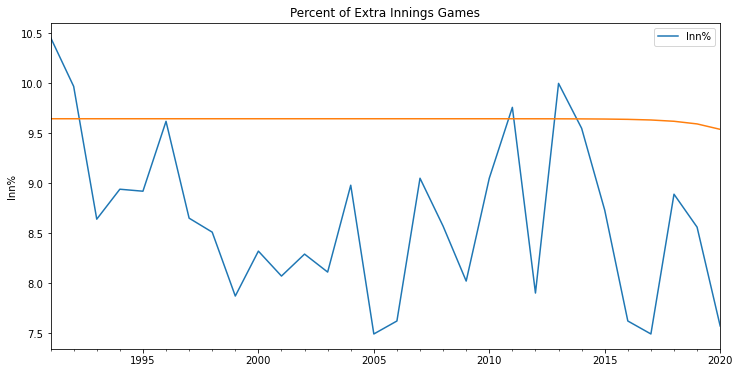

In [199]:
title = 'Percent of Extra Innings Games'
ylabel='Inn%'
xlabel='' # we don't really need a label here

ax = test['Inn%'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot()
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [255]:
for num, i in enumerate(df1['Time']):
    hours, minutes = i.split(':')
    df1['Time'][num] = int(hours) * 60 + int(minutes)

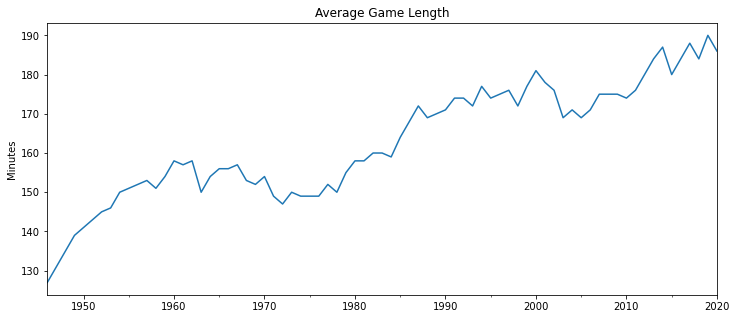

In [241]:
title = 'Average Game Length'
ylabel='Minutes'
xlabel='' # we don't really need a label here

ax = df1['Time'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [242]:
auto_arima(df1['Time'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   75
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -180.856
Date:                Sun, 14 Feb 2021   AIC                            373.713
Time:                        14:30:21   BIC                            387.537
Sample:                             0   HQIC                           379.228
                                 - 75                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8864      1.322      2.183      0.029       0.295       5.478
ar.L1         -1.6245      0.057    -28.396      0.000      -1.737      -1.512
ar.L2         -0.9727      0.050    -19.420      0.000      -1.071      -0.875
ma.L1          1.6940      0.125     13.578      0.000       1.449       1.938
ma.L2          0.9568      0.131      7.319      0.000       0.701       1.213
sigma2         7.4007      1.512      4.895      0.000       4.438      10.364
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.88   Prob(JB):                         0.28
Heteroskedasticity (H):               1.25   Skew:                            -0.45
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [243]:
from statsmodels.tsa.statespace.tools import diff
df1['d1'] = diff(df1['Time'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df1['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic      -3.497353
p-value                  0.008055
# lags used              4.000000
# observations          69.000000
critical value (1%)     -3.528890
critical value (5%)     -2.904440
critical value (10%)    -2.589656
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


A PACF Plot can reveal recommended AR(p) orders, and an ACF Plot can do the same for MA(q) orders.
Alternatively, we can compare the stepwise Akaike Information Criterion (AIC) values across a set of different (p,q) combinations to choose the best combination.

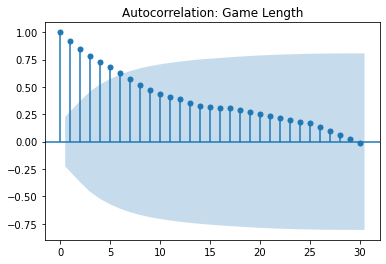

In [244]:
title = 'Autocorrelation: Game Length'
lags = 30
plot_acf(df1['Time'],title=title,lags=lags);

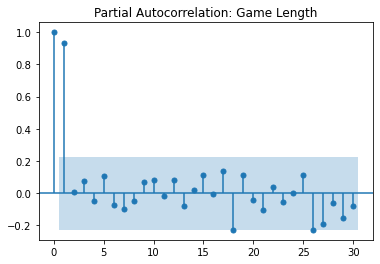

In [245]:
title = 'Partial Autocorrelation: Game Length'
lags = 30
plot_pacf(df1['Time'],title=title,lags=lags);

From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [246]:
stepwise_fit = auto_arima(df1['Time'], start_p=0, start_q=0,
                          max_p=4, max_q=4, m=20,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=382.363, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=382.464, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=382.393, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=385.046, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=384.393, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.110 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   75
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -189.181
Date:                Sun, 14 Feb 2021   AIC                            382.363
Time:                        14:30:22   BIC                            386.971
Sample:                             0   HQIC                           384.201
                                 - 75                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7973      0.420      1.899      0.058      -0.026       1.620
sigma2         9.7292      1.834      5.305      0.000       6.135      13.324
===================================================================================
Ljung-Box (L1) (Q):                   1.89   Jarque-Bera (JB):                 6.40
Prob(Q):                              0.17   Prob(JB):                         0.04
Heteroskedasticity (H):               1.53   Skew:                            -0.72
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [247]:
len(df1)

75

In [257]:
# Set one year for testing
test = df1.iloc[60:]
train = df1.iloc[:60]

In [259]:
model = ARIMA(np.asarray(df1['Time']),order=(0,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   74
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -189.181
Method:                           css   S.D. of innovations              3.119
Date:                Sun, 14 Feb 2021   AIC                            382.363
Time:                        14:32:04   BIC                            386.971
Sample:                             1   HQIC                           384.201
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7973      0.363      2.199      0.028       0.087       1.508
==============================================================================
"""

In [260]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = pd.DataFrame(results.predict(start=start, end=end, dynamic=False, typ='levels'))

In [261]:
predictions.index = test.index
predictions.columns = ['Predicted Time']

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [262]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions['Predicted Time'][i]}, expected={test['Time'][i]}")

predicted=169.7972972972973, expected=171
predicted=171.7972972972973, expected=175
predicted=175.7972972972973, expected=175
predicted=175.7972972972973, expected=175
predicted=175.7972972972973, expected=174
predicted=174.7972972972973, expected=176
predicted=176.7972972972973, expected=180
predicted=180.7972972972973, expected=184
predicted=184.7972972972973, expected=187
predicted=187.7972972972973, expected=180
predicted=180.7972972972973, expected=184
predicted=184.7972972972973, expected=188
predicted=188.7972972972973, expected=184
predicted=184.7972972972973, expected=190
predicted=190.7972972972973, expected=186


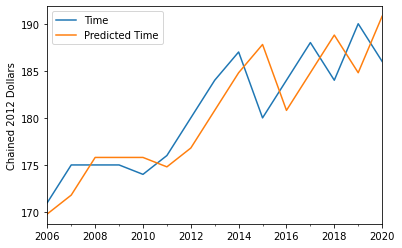

In [263]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Time'].plot(legend=True)
ax = predictions['Predicted Time'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [278]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Time'], predictions['Predicted Time'])
print(f'ARIMA(0,1,0) MSE Error: {error:.5}')

ARIMA(0,1,0) MSE Error: 13.162


In [279]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Time'], predictions['Predicted Time'])
print(f'ARIMA(0,1,0) RMSE Error: {error:.5}')

ARIMA(0,1,0) RMSE Error: 3.6279


In [306]:
model = ARIMA(np.asarray(df1['Time']),order=(0,1,0))
results = model.fit()
fcast = results.predict(len(df1),len(df1)+10,typ='levels')

In [333]:
future_dates = pd.Series(range(2021,2032))
future_dates = [str(x) for x in future_dates]
game_time_forecast = pd.DataFrame({'Year':future_dates, 'forecast': fcast})
game_time_forecast = game_time_forecast.set_index('Year')


In [337]:
game_time_forecast.index = pd.to_datetime(game_time_forecast.index)

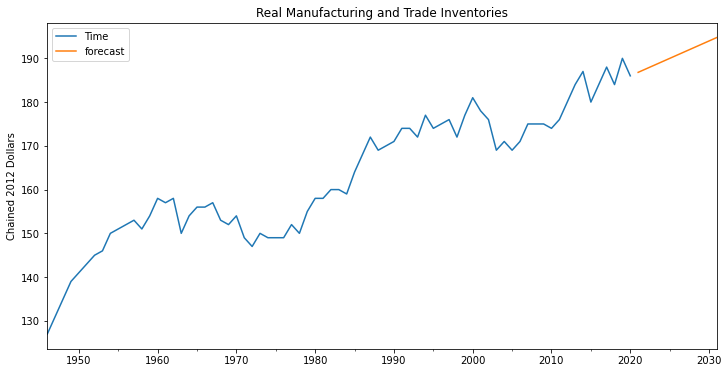

In [338]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df1['Time'].plot(legend=True,figsize=(12,6),title=title)
game_time_forecast['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html'>arima_model.ARMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Moving Average ARMA(p,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.html'>arima_model.ARMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;Class to hold results from fitting an ARMA model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html'>arima_model.ARIMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Integrated Moving Average ARIMA(p,d,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.html'>arima_model.ARIMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;Class to hold results from fitting an ARIMA model<br>	
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.kalmanf.kalmanfilter.KalmanFilter.html'>kalmanf.kalmanfilter.KalmanFilter</a></strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kalman Filter code intended for use with the ARMA model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive–moving-average model</font><br>
<strong>
<a href='https://otexts.com/fpp2/non-seasonal-arima.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Non-seasonal ARIMA models</font></div>